In [1]:
import re
import pickle
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from konlpy.tag import Okt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로드

In [258]:
data = pd.read_csv("data/hate_speech_large.csv")
data.columns = ["comments", "label"]
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1


In [259]:
print("댓글 개수 :",len(data)) # 댓글 개수 출력

댓글 개수 : 190000


## 데이터 정제

In [260]:
data['label'] = np.where(data['label'] == 0, 1, 0)

### 댓글의 중복 여부 확인

In [261]:
data['comments'].nunique(), data['label'].nunique()

(187142, 2)

In [262]:
data.drop_duplicates(subset=['comments'], inplace=True) # 중복 코멘트 제거
data.shape

(187143, 2)

In [263]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 187143


#### 레이블 값의 분포

<AxesSubplot:>

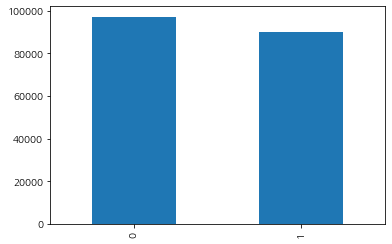

In [264]:
data['label'].value_counts().plot(kind = 'bar')

In [265]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  97223
1      1  89920


### Null 값 제거

In [266]:
print(data.isnull().values.any())

True


In [267]:
print(data.isnull().sum())

comments    1
label       0
dtype: int64


In [268]:
data.loc[data.comments.isnull()]

,comments,label
7807,NaN,0


In [269]:
data = data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [270]:
print(len(data))

187142


### 한글, 공백 제외 전처리

In [271]:
data['comments'] = data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,0
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,0
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,1
3,착한아이임당 용지 덮고,1
4,진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다 네티즌전문가 하나같이 영...,0


In [272]:
data['comments'] = data['comments'].str.strip()
data['comments'].replace('', np.nan, inplace=True)
print(data.isnull().sum())

comments    1021
label          0
dtype: int64


In [275]:
data = data.dropna(how = 'any')
print(len(data))

186121


### 데이터 분리

In [276]:
train_data = data[:150000]
test_data = data[150000:]

train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

In [37]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

## EDA

### 워드클라우드
* 긍정/부정 댓글에서 빈도수가 가장 높은 명사들을 시각화

명사 추출 함수

In [ ]:
def get_nouns(data, label):
    okt = Okt()
    subset = data[data['label'] == label]
    text = subset['comments']
    
    morphs = []
    for sentence in text:
        morphs.append(okt.pos(sentence))

    nouns = []
    for morph in morphs:
        for word, tag in morph:
            if tag in ['Noun']:
                nouns.append(word)
    
    count = Counter(nouns)
    words = dict(count.most_common())
    
    return words

positive = get_nouns(train_data, 0)
negative = get_nouns(train_data, 1)

워드 클라우드 생성 함수

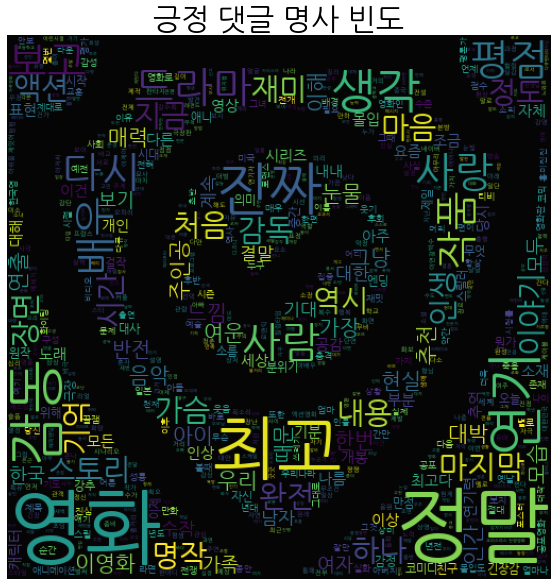

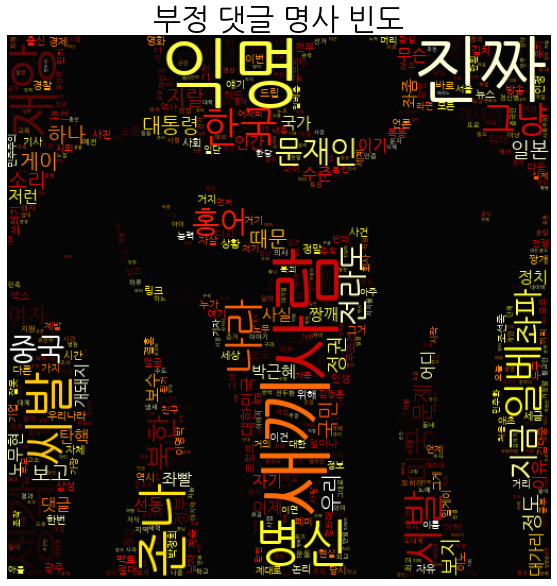

In [129]:
def generate_word_cloud(data, img, title, cmap):
    clean_mask = np.array(Image.open("data/img/" + str(img) + ".png"))
    clean_mask = clean_mask[:,:,1]

    wc = WordCloud(font_path ='C:/Windows/Fonts/NanumGothic.ttf', 
                   background_color ="black",
                   max_words = 2000,
                   mask = clean_mask,
                   stopwords = stopwords)

    wc.generate(" ".join(data))
    plt.figure(figsize = (20, 10))
    plt.axis("off")
    plt.title(title, fontsize = 30)
    plt.imshow(wc.recolor(colormap = cmap, random_state = 17), alpha = 0.98)
    plt.savefig(title + ".png")

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
generate_word_cloud(positive, "safe-zone", "긍정 댓글 명사 빈도", "viridis")
generate_word_cloud(negative, "anger", "부정 댓글 명사 빈도", "hot")

## 토큰화

In [38]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [39]:
okt = Okt()
X_train = []
for sentence in train_data['comments']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [57]:
print(X_train[0])

['정말', '재밌다', '연기', '좋다', '디카프리오', '짱']


In [41]:
X_test = []
for sentence in test_data['comments']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [58]:
print(X_test[0])

['문채원', '짱', '너무나', '사랑스럽다', '귀엽다', '문채원', '매력', '푹', '빠지다', '보다']


In [43]:
with open("data/okt_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
    
with open("data/okt_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

# 여기서 시작 ---------------------------------------------------------

In [ ]:
import re
import pickle
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from konlpy.tag import Okt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### okt

In [ ]:
with open("data/okt_train.pkl", "rb") as f:
    X_train = pickle.load(f)
    
with open("data/okt_test.pkl", "rb") as f:
    X_test = pickle.load(f)

In [79]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

## 정수 인코딩

In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [60]:
print(len(tokenizer.word_index))

56246


In [61]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 56246
등장 빈도가 2번 이하인 희귀 단어의 수: 31118
단어 집합에서 희귀 단어의 비율: 55.32482309853145
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.119818367596178


In [62]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 25130


In [63]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [64]:
print(X_train[:3])

[[21, 17, 54, 8, 3090, 130], [21036, 216, 13736, 1235, 2155, 3000, 305, 1069, 9532, 305], [368, 6, 320, 447, 51, 67, 698, 98, 10]]


In [65]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거

In [66]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
len(drop_train)

15

In [67]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

149985
149985


## 패딩

리뷰의 최대 길이 : 468
리뷰의 평균 길이 : 12.065133179984665


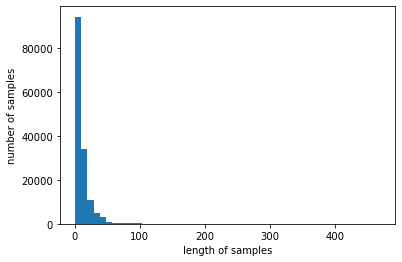

In [68]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [69]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [70]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.35716905023835


In [71]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## LSTM으로 악성 댓글 분류

In [72]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [73]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('1best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Train on 119988 samples, validate on 29997 samples
Epoch 1/15
119820/119988 [============================>.] - ETA: 0s - loss: 0.1906 - acc: 0.9241
Epoch 00001: val_acc improved from -inf to 0.93889, saving model to 1best_model.h5
119988/119988 [==============================] - 27s 229us/sample - loss: 0.1905 - acc: 0.9241 - val_loss: 0.1605 - val_acc: 0.9389
Epoch 2/15
119880/119988 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.9432
Epoch 00002: val_acc improved from 0.93889 to 0.94049, saving model to 1best_model.h5
119988/119988 [==============================] - 25s 210us/sample - loss: 0.1447 - acc: 0.9432 - val_loss: 0.1527 - val_acc: 0.9405
Epoch 3/15
119880/119988 [============================>.] - ETA: 0s - loss: 0.1329 - acc: 0.9483
Epoch 00003: val_acc improved from 0.94049 to 0.94316, saving model to 1best_model.h5
119988/119988 [==============================] - 26s 214us/sample - loss: 0.1329 - acc: 0.9483 - val_loss: 0.1425 - val_acc: 0.9432
Epoch 4

In [75]:
loaded_model = load_model('1best_model.h5')
print("\n테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

36121/36121 [==============================] - 8s 208us/sample - loss: 0.1344 - acc: 0.9477

테스트 정확도: 0.9477


In [77]:
def sentiment_predict(new_sentence):
    sent = new_sentence
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{}: {:.2f}% --.\n".format(sent, score * 100))
    else:
        print("{}: {:.2f}% ++.\n".format(sent, (1 - score) * 100))

In [78]:
for sentence in test_data['comments'][:1]:
    sentiment_predict(sentence)

문채원 짱 너무나 사랑스럽고 귀엽고 문채원의 매력에 푹 빠져보세요: 99.96% ++.

